<a href="https://colab.research.google.com/github/ludovicolc/Indeed_jobs_project/blob/main/indeed_jobs_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Esplorazione & Analisi offerte di lavoro estratte da indeed.com 

### Scopo principale del progetto
Attraverso questo programma è possibile ottenere informazioni chiave riguardo le offerte lavorative di un detrminato settore di interesse, potendo così comprendere cosa è necessario per raggiungere una determinata posizione lavorativa e cosa si può ottenere in cambio in termini di remunerazione.

Nello specifico in questo progetto sono state analizzate le offerte relative all'analisi dei dati in Italia ma è possibile variare luogo, settore e requisiti in base alle proprie preferenze. 




### Fasi del progetto
1.   Estrazione e trasformazione dati
2.   Rielaborazione DataFrame & Pulizia Dati
3.   Analisi dei dati








# Libraries

In [ ]:
# Scraping
import requests
from bs4 import BeautifulSoup as bs
import time
# Gestione dati
import pandas as pd
import numpy as np
# Visualizzazioni
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
sns.set_style("darkgrid")
sns.set_palette('viridis')

# 1. Estrazione e trasformazione dati
Note funzione extract():
*   in country necessario utilizzo TLD (Top Level Domain) es. Italia = it
*   in job si possono inserire più posizioni; %2C rappresenta la virgola mentre %20 rappresenta una spaziatura
*   region viene utilizzato assieme alle regioni del territorio per implementare la funzione di ricerca, questo perchè se non viene effettuata una ricerca suddivisa indeed ritorna solo una parte delle ricerche ovvero 100 pagine circa
*   radius identifica il raggio in cui cercare le offerte partendo da una posizione iniziale (città-regione) e può assumere i seguenti valori in km: 0, 10, 25, 50, 75, 100


In [ ]:
# Estrazione pagine
def extract(job, region, page, country='it', city='', radius=0):
    headers = {'User-Agent': 'Mozilla/5.0 (X11; CrOS x86_64 14816.82.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36'}
    url = f'https://{country}.indeed.com/jobs?q={job}&l={city}%2C+{region}&filter=0&start={page}&radius={radius}'
    response = requests.get(url, headers=headers)
    soup = bs(response.content, 'html.parser')
    return soup

# Trasformazione pagine estratte (raccolta informazioni grezze) 
def transform(soup):
    headers = {'User-Agent': 'Mac OS X10/Safari browser: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9'}
    divs = soup.find_all('div', class_ = 'slider_container css-g7s71f eu4oa1w0')

    for items in divs:
        posizione = items.find('a').text.strip()
        location = items.find('div', class_ = 'companyLocation').text.strip()
        azienda = items.find('span', class_ = 'companyName').text.strip()
        try:
            rating = items.find('span', class_ = 'ratingNumber').text
        except:
            rating = ''
        try:
            stipendio = items.find('div', class_ = 'metadata salary-snippet-container').get_text()
        except:
            stipendio = '' 
        link = 'https://it.indeed.com' + items.find('a', class_='jcs-JobTitle css-jspxzf eu4oa1w0').get('href')
        link_response = requests.get(link, headers=headers)
        link_soup = bs(link_response.content, 'html.parser')
        link_texts = link_soup.find('div', class_='jobsearch-JobComponent-description icl-u-xs-mt--md')
        if link_texts is not None:
            descrizione = link_texts.get_text(strip=True)
        else:
            descrizione = np.nan

        dati = {
            'Posizione': posizione,
            'Location': location,
            'Nome_azienda': azienda,
            'Rating_azienda': rating,
            'Stipendio': stipendio,
            'Descrizione': descrizione
        }
        jobs.append(dati)
    return 

## Creazione DataFrame

In [ ]:
# Regioni Italiane per ricerca offerte
regioni_italiane = [
                    'emilia-romagna', 'friuli-venezia giulia', 'liguria', 'lombardia', 'piemonte',
                    'trentino-alto adige', 'valle d\'aosta', 'veneto', 'toscana',  'umbria', 'lazio',
                    'marche', 'abruzzo', 'basilicata', 'calabria', 'campania', 'molise', 'puglia', 'sardegna', 'sicilia'
                    ]

In [ ]:
# Ricerca offerte per regione e su più pagine
jobs = []
page = 0
for regione in regioni_italiane:
    while True: 
        ext = extract('data%2C%20dati%2C%20analyst%2C%20analista', regione, page)
        transform(ext)
        if not ext.find('a', {'aria-label': 'Prossima'}):
            break
        page = page + 10
    time.sleep(1)

In [ ]:
# Creazione Dataframe
df_joblist = pd.DataFrame(jobs)

Struttura Dataframe grezzo

In [ ]:
# Struttura
df_joblist.shape

In [ ]:
df_joblist.head()

,Posizione,Location,Nome_azienda,Rating_azienda,Stipendio,Descrizione
0,FINANCIAL ANALYST,"Bologna, Emilia-Romagna",Unipol Gruppo Finanziario S.p.A.,"3,8",,"UNIPOLSAI ASSICURAZIONI S.p.A., Compagnia di A..."
1,Strategic Marketing Analyst,"Parma, Emilia-Romagna",Sidel,"3,9",,Sidel is looking for a talented marketing anal...
2,QA Analyst,"Bologna, Emilia-Romagna",KANTAR,"3,7",,Dettagli offerta di lavoroTipo di offerta di l...
3,Corporate Credit Analyst,"Bologna, Emilia-Romagna",Page Personnel Italia,"2,6",€50.000 all'anno,Dettagli offerta di lavoroStipendio€50.000 all...
4,SENIOR FEM/CFD ANALYST,"Bologna, Emilia-Romagna",NIER Ingegneria,"3,3",,DESCRIZIONE OFFERTA DI LAVORONIER Ingegneria i...


# 2. Rielaborazione DataFrame & Pulizia Dati

### Posizione

In [ ]:
# Pulizia e riordinamento di base
df_joblist['Posizione'] = df_joblist['Posizione'].str.strip()

### Location
Note:
*   per una migliore comprensione ed analisi le città sono state separate dalle proprie regioni di appartenenza creando 2 nuove colonne 



In [ ]:
# Pulizia e riordinamento di base
df_joblist['Location'] = df_joblist['Location'].str.lower()

# Rimozione codice postale
str_range = [str(n) for n in [r for r in range(0, 10)]]
for x in str_range:
  df_joblist['Location'] = df_joblist['Location'].str.replace(x, '')

In [ ]:
# Standardizzazione offerte 'da remoto'
for x in df_joblist['Location']:
    if 'da remoto' in x:
        df_joblist['Location'] = df_joblist['Location'].str.replace(x, 'da remoto, da remoto')

In [ ]:
# Separazione città-regione
df_joblist['Città'], df_joblist['Regione'] = df_joblist['Location'].str.split(', ', 1).str

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


In [ ]:
# Trasferimento regioni rimaste in colonna città
regioni = ['abruzzo', 'basilicata', 'calabria', 'campania', 'emilia-romagna', 'friuli-venezia giulia',
           'lazio', 'liguria', 'lombardia', 'marche', 'molise', 'piemonte', 'puglia', 'sardegna', 'sicilia',
           'toscana', 'trentino-alto adige', 'umbria', 'valle d\'aosta', 'veneto']

regioni_in_città = df_joblist[df_joblist['Città'].isin(regioni)].index.tolist()
for reg in regioni_in_città:
    df_joblist['Regione'][reg] = df_joblist['Città'][reg]
    df_joblist['Città'][reg] = np.nan

In [ ]:
# Osservare se presenti parole/simboli non coerenti
df_joblist['Città'].unique()

In [ ]:
# Rimozione parole/simboli non coerenti
df_joblist['Città'] = df_joblist['Città'].str.replace('provincia di ', '').str.strip()

In [ ]:
# Osservare se presenti parole/simboli non coerenti
df_joblist['Regione'].unique()

array(['emilia-romagna', nan, 'da remoto', 'friuli-venezia giulia',
       'liguria', 'lombardia', 'piemonte', 'trentino-alto adige',
       "valle d'aosta", 'veneto', 'toscana', 'umbria', 'lazio', 'marche',
       'abruzzo', 'calabria', 'campania', 'molise', 'puglia', 'sardegna',
       'sicilia'], dtype=object)

In [ ]:
# Rimozione parole/simboli non coerenti
df_joblist['Regione'] = df_joblist['Regione'].str.replace('\+ luogo', '').str.strip()
df_joblist['Regione'] = df_joblist['Regione'].str.replace('\+ luoghi', '').str.strip()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
# Eliminazione colonna 'Location'
df_joblist = df_joblist.drop(columns='Location')

### Nome_azienda

In [ ]:
# Pulizia e riordinamento di base
df_joblist['Nome_azienda'] = df_joblist['Nome_azienda'].str.strip()

### Rating_azienda

In [ ]:
# Pulizia e riordinamento di base
df_joblist['Rating_azienda'] = df_joblist['Rating_azienda'].str.replace(',', '.')
df_joblist['Rating_azienda'] = pd.to_numeric(df_joblist['Rating_azienda'])

### Stipendio

In [ ]:
# Pulizia e riordinamento di base
rimuovere = ['€', '.', 'all\'anno']
for x in rimuovere:
    df_joblist['Stipendio'] = df_joblist['Stipendio'].str.replace(x, '') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Estrazione stipendio più elevato da range stipendi; es. 1000-1100 = 1100
for x in df_joblist['Stipendio']:
    if '-' in x:
        df_joblist['Stipendio'] = df_joblist['Stipendio'].str.replace(x, x[x.index('-')+1:])

Conversione stipendi orari-giornalieri-mensili in annuali

Ipotesi di base:
*   da mensile ad annuale: 12 mesi in un anno
*   da giornaliero ad annuale: 22 giorni al mese
*   da orario ad annuale: 8 ore al giorno 



In [ ]:
# Liste per identificare stipendi da convertire
index_m = df_joblist.index[df_joblist['Stipendio'].str.contains('al mese')].tolist()
index_g = df_joblist.index[df_joblist['Stipendio'].str.contains('al giorno')].tolist()
index_o = df_joblist.index[df_joblist['Stipendio'].str.contains('all\'ora')].tolist()
# Rimozione unità di misura
df_joblist['Stipendio'] = df_joblist['Stipendio'].str.replace(' al mese', '')
df_joblist['Stipendio'] = df_joblist['Stipendio'].str.replace(' al giorno', '')
df_joblist['Stipendio'] = df_joblist['Stipendio'].str.replace(' all\'ora', '')
# Conversione in annuali
df_joblist['Stipendio'] = pd.to_numeric(df_joblist['Stipendio'])
df_joblist['Stipendio'][index_m] = df_joblist['Stipendio'][index_m] * 12
df_joblist['Stipendio'][index_g] = df_joblist['Stipendio'][index_g] * 264
df_joblist['Stipendio'][index_o] = df_joblist['Stipendio'][index_o] * 2112

### Descrizione

In [ ]:
# Pulizia e riordinamento di base
df_joblist['Descrizione'] = df_joblist['Descrizione'].str.lower()

rimuovere = [',', '.', ':', ';', '/', '-']
for x in rimuovere:
    df_joblist['Descrizione'] = df_joblist['Descrizione'].str.replace(x, ' ') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """


Ricerca esperienza richiesta 

In [ ]:
# Creazione colonna Esperienza_in_anni
exp = []
for x in df_joblist['Descrizione'].astype(str):
    if ' anno ' in x:
        exp.append(x.split(' ')[x.split(' ').index('anno') - 1])
    elif ' anni ' in x:
        exp.append(x.split(' ')[x.split(' ').index('anni') - 1])
    elif ' year ' in x:
        exp.append(x.split(' ')[x.split(' ').index('year') - 1])
    elif ' years ' in x:
        exp.append(x.split(' ')[x.split(' ').index('years') - 1])
    elif ' years\' ' in x:
        exp.append(x.split(' ')[x.split(' ').index('years\'') - 1])
    elif ' year\'s ' in x:
        exp.append(x.split(' ')[x.split(' ').index('year\'s') - 1])
    else:
        exp.append(0)

# Sostituzione eventuali numeri 1-2 espressi in forma letterale
exp1 = [1 if e == 'un' or e == 'one' else e for e in exp]
exps = [2 if e == 'due' or e == 'two' else e for e in exp1]

df_joblist['Esperienza_in_anni'] = exps
# Conversione in valori numerici
df_joblist['Esperienza_in_anni'] = pd.to_numeric(df_joblist['Esperienza_in_anni'], errors ='coerce')

Ricerca requisiti richiesti

Note:
*   i requisiti_primari sono quelli che verrano poi esposti ed analizzati ed andranno a comprendere anche i requisiti_secondari grazie alla funzione union()
*   i requisiti_secondari rappresentano requisiti che, pur avendo una denominazione differente, nella sostanza possono essere assimilati ai requisiti_primari 
*   a scelta si possono aggiungere e rimuovere i vari requisiti ricercati, sia primari che secondari



In [ ]:
# Funzione per identificare requisiti dentro le offerete
def identificare(requisito):
    vals = [] 
    for x in df_joblist['Descrizione'].astype(str):
      if x.count(f'{requisito}') > 0:
        vals.append('si')
      else:
        vals.append(np.nan) 
    df_joblist[f'{requisito}'] = vals

In [ ]:
# Requisiti ricercati
requisiti_primari = ['laurea', 'inglese', 'excel', 'sql', 'python', ' r ', 'tableau', ' bi ']
requisiti_secondari = ['english', 'degree', 'business intelligence']
reqs = requisiti_primari + requisiti_secondari
for req in reqs:
    identificare(req)

In [ ]:
# Funzione per unire colonne aventi stesso significato ma nomi differenti
def union(req_primario, req_secondario):
    global df_joblist
    df_joblist[f'{req_primario}'] = np.where((df_joblist[f'{req_primario}'] == 'no') & 
                                             (df_joblist[f'{req_secondario}'] == 'si'),
                                             'si', df_joblist[f'{req_primario}'])
    df_joblist = df_joblist.drop(columns=f'{req_secondario}')

In [ ]:
# Coppie di requisiti da unire
unione = [('laurea', 'degree'), ('inglese', 'english'), (' bi ', 'business intelligence')]
for x, y in unione:
    union(x, y)

In [ ]:
# Creazione colonna requisiti totali per posizione
df_joblist['Requisiti_tot'] = df_joblist.iloc[:, -8:-1].count(axis=1)

In [ ]:
# Eliminazione colonna 'Descrizione'
df_joblist = df_joblist.drop(columns='Descrizione')

DataFrame rielaborato

In [ ]:
df_joblist.head()

,Posizione,Nome_azienda,Rating_azienda,Stipendio,Città,Regione,Esperienza_in_anni,laurea,inglese,excel,sql,python,r,tableau,bi,Requisiti_tot
0,FINANCIAL ANALYST,Unipol Gruppo Finanziario S.p.A.,3.8,NaN,bologna,emilia-romagna,0.0,si,NaN,NaN,si,NaN,NaN,NaN,NaN,2
1,Strategic Marketing Analyst,Sidel,3.9,NaN,parma,emilia-romagna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,QA Analyst,KANTAR,3.7,NaN,bologna,emilia-romagna,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Corporate Credit Analyst,Page Personnel Italia,2.6,50000.0,bologna,emilia-romagna,3.0,si,si,si,NaN,NaN,NaN,NaN,NaN,3
4,SENIOR FEM/CFD ANALYST,NIER Ingegneria,3.3,NaN,bologna,emilia-romagna,NaN,NaN,NaN,NaN,NaN,si,NaN,NaN,NaN,1


In [ ]:
# Creazione file csv
df_joblist.to_csv('.csv')

# 3. Analisi dei dati

Struttura Dataframe rielaborato

In [ ]:
# Struttura
df_joblist.shape

(1238, 16)

In [ ]:
# Informazioni generiche
df_joblist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1238 entries, 0 to 1237
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Posizione           1238 non-null   object 
 1   Nome_azienda        1238 non-null   object 
 2   Rating_azienda      718 non-null    float64
 3   Stipendio           92 non-null     float64
 4   Città               1221 non-null   object 
 5   Regione             1087 non-null   object 
 6   Esperienza_in_anni  1082 non-null   float64
 7   laurea              658 non-null    object 
 8   inglese             590 non-null    object 
 9   excel               408 non-null    object 
 10  sql                 330 non-null    object 
 11  python              98 non-null     object 
 12   r                  86 non-null     object 
 13  tableau             51 non-null     object 
 14   bi                 68 non-null     object 
 15  Requisiti_tot       1238 non-null   int64  
dtypes: flo

Visionare duplicati e valori nulli

In [ ]:
# Duplicati
df_joblist.duplicated().sum()

0

In [ ]:
# Identificazione duplicati
df_joblist[df_joblist.duplicated(keep=False)]

In [ ]:
# Eliminazione duplicati
df_joblist.drop_duplicates(inplace=True)

In [ ]:
# Valori nulli
df_joblist.isnull().sum()

Posizione                0
Nome_azienda             0
Rating_azienda         488
Stipendio             1101
Città                   16
Regione                143
Esperienza_in_anni     140
laurea                 564
inglese                639
excel                  799
sql                    876
python                1102
 r                    1113
tableau               1149
 bi                   1128
Requisiti_tot            0
dtype: int64

Prime osservazioni riguardanti i valori numerici

In [ ]:
df_joblist.describe()

,Rating_azienda,Stipendio,Esperienza_in_anni,Requisiti_tot
count,704.000000,91.000000,1052.000000,1192.000000
mean,3.628977,30525.065934,2.918251,1.763423
std,0.447291,15690.758135,8.525050,1.149338
min,2.000000,35.000000,0.000000,0.000000
25%,3.400000,28000.000000,0.000000,1.000000
50%,3.700000,35000.000000,0.000000,2.000000
75%,3.900000,39250.000000,3.000000,2.000000
max,5.000000,66000.000000,130.000000,7.000000


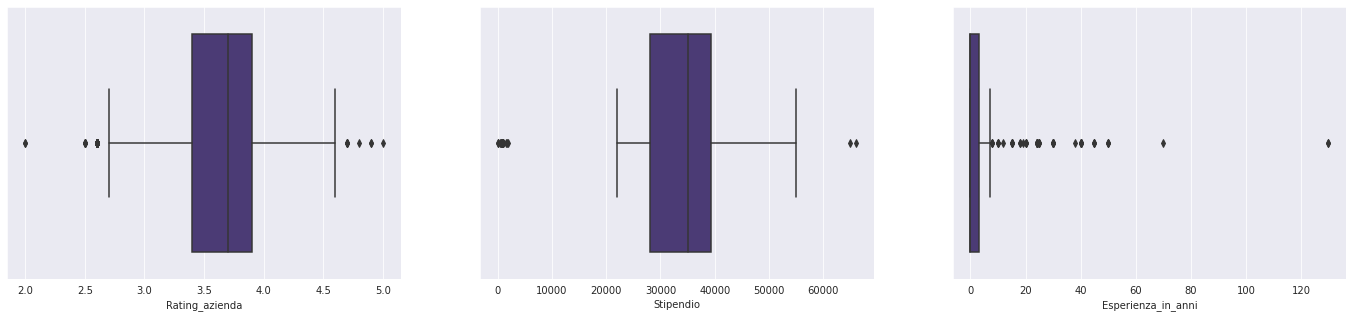

In [ ]:
# Distribuzione principali valori numerici
fig, axs = plt.subplots(ncols=3, figsize=(24, 5))
sns.boxplot(x='Rating_azienda', data=df_joblist, ax=axs[0])
sns.boxplot(x='Stipendio', data=df_joblist, ax=axs[1])
sns.boxplot(x='Esperienza_in_anni', data=df_joblist, ax=axs[2])

Come si può osservare dal boxplot, la colonna 'Esperienza_in_anni' detiene un'elevata presenza di outliers, il motivo principale deriva dalla funzione utilizzata per l'estrazione del numero di anni che riporta anche, in alcuni casi, gli anni di attività dell'azienda offerente.
Ossevazioni e interventi:
*   generalmente l'esperienza richiesta va da un minimo di 0 anni fino ad un massimo di circa 10 anni
*   tipicamente le aziende che mostrano gli anni di attività sono quelle più mature (anni > 10)
*   in alcuni casi l'esperienza non viene esplicitata in numero di anni ma viene richiesta per alcune posizioni in modo generico (principalmente quando si tratta di una posizione di 'grado' elevato)
*   per rendere il campione statistico il più rilevante possibile sono stati rimossi gli outliers attraverso l'utilizzo del metodo IQR con 3 deviazioni standard

In [ ]:
# Identificazione quartili e IQR
Q1_exp = df_joblist['Esperienza_in_anni'].quantile(0.25)
Q3_exp = df_joblist['Esperienza_in_anni'].quantile(0.75)
IQR_exp = Q3_exp - Q1_exp

In [ ]:
# Assegnazione valori nulli agli outliers
for exp in df_joblist['Esperienza_in_anni']:
    if exp < (Q1_exp - 1.7 * IQR_exp):
        df_joblist['Esperienza_in_anni'] = df_joblist['Esperienza_in_anni'].replace(exp, np.nan)
    elif exp > (Q3_exp + 1.7 * IQR_exp):
        df_joblist['Esperienza_in_anni'] = df_joblist['Esperienza_in_anni'].replace(exp, np.nan)

In [ ]:
df_joblist.describe()

,Rating_azienda,Stipendio,Esperienza_in_anni,Requisiti_tot
count,704.000000,91.000000,1004.000000,1192.000000
mean,3.628977,30525.065934,1.483068,1.763423
std,0.447291,15690.758135,1.947136,1.149338
min,2.000000,35.000000,0.000000,0.000000
25%,3.400000,28000.000000,0.000000,1.000000
50%,3.700000,35000.000000,0.000000,2.000000
75%,3.900000,39250.000000,3.000000,2.000000
max,5.000000,66000.000000,8.000000,7.000000


Visualizzazione delle parole più ricorrenti all'interno delle offerte di lavoro

In [ ]:
# Creazione testo contenente tutte le posizioni
parole = ''.join([x.lower()+' ' for x in df_joblist['Posizione']])

In [ ]:
# Creazione wordcloud
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 2000, height = 800, background_color ='black', 
                      colormap='viridis', stopwords = stopwords,
                      min_font_size = 10).generate(parole)

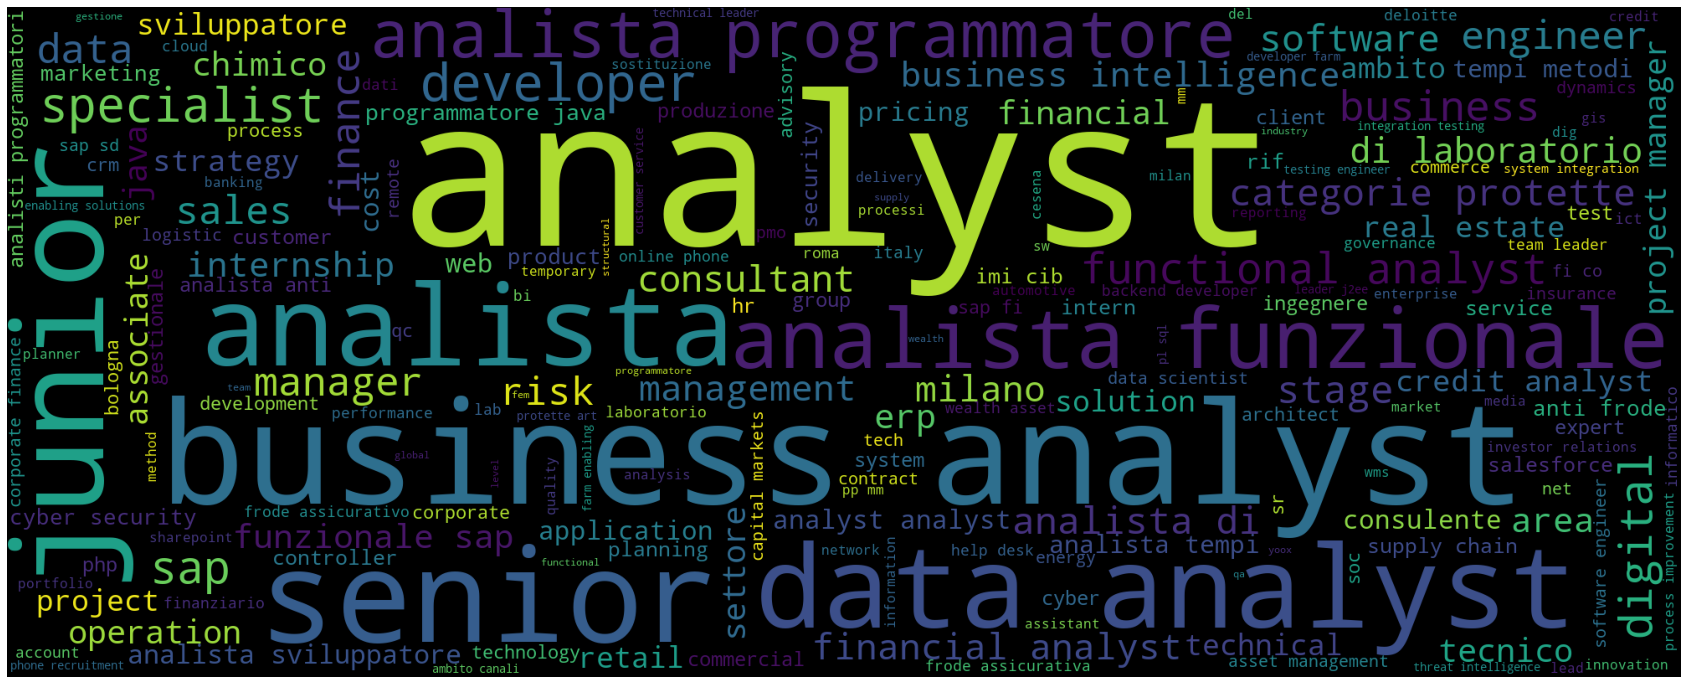

In [ ]:
# Visualizzazione wordcloud
plt.figure(figsize = (30, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Osservazione offerte in termini di qualità aziendale (Rating_azienda) e Stipendio 

In [ ]:
# Offerta/e con rating massimo
df_joblist[df_joblist['Rating_azienda'] == df_joblist['Rating_azienda'].max()]

,Posizione,Nome_azienda,Rating_azienda,Stipendio,Città,Regione,Esperienza_in_anni,laurea,inglese,excel,sql,python,r,tableau,bi,Requisiti_tot
1075,ANALISTA FUNZIONALE SAP,Cogne Acciai Speciali S.p.A.,5.0,NaN,aosta,NaN,3.0,si,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
# Offerta/e con rating minimo
df_joblist[df_joblist['Rating_azienda'] == df_joblist['Rating_azienda'].min()]

,Posizione,Nome_azienda,Rating_azienda,Stipendio,Città,Regione,Esperienza_in_anni,laurea,inglese,excel,sql,python,r,tableau,bi,Requisiti_tot
966,Analista Programmatore Area ERP,SB Italia,2.0,NaN,garbagnate milanese,lombardia,0.0,NaN,NaN,NaN,si,NaN,NaN,NaN,NaN,1
1025,Analista Programmatore Area Digital Transforma...,SB Italia,2.0,NaN,garbagnate milanese,lombardia,0.0,NaN,si,NaN,si,NaN,NaN,NaN,NaN,2


In [ ]:
# Offerta/e con stipendio massimo
df_joblist[df_joblist['Stipendio'] == df_joblist['Stipendio'].max()]

,Posizione,Nome_azienda,Rating_azienda,Stipendio,Città,Regione,Esperienza_in_anni,laurea,inglese,excel,sql,python,r,tableau,bi,Requisiti_tot
78,Analista Funzionale ICT ambito Wealth Management,Hunters Group,NaN,66000.0,da remoto,da remoto,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
# Offerta/e con stipendio minimo
df_joblist[df_joblist['Stipendio'] == df_joblist['Stipendio'].min()]

,Posizione,Nome_azienda,Rating_azienda,Stipendio,Città,Regione,Esperienza_in_anni,laurea,inglese,excel,sql,python,r,tableau,bi,Requisiti_tot
733,Analista tempi e metodi- Provincia di Mantova,Page Personnel Italia,2.6,35.0,mantova,lombardia,NaN,si,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
743,Insurance PMO - Analista funzionale,Page Personnel Italia,2.6,35.0,da remoto,da remoto,2.0,si,si,NaN,NaN,NaN,NaN,NaN,NaN,2


Quante offerte richiedono esperienza (anche minima) e quante offerte mostrano lo Stipendio che verrà corrisposto

In [ ]:
# Percentuale di offerte che richiedono esperienza di almeno 1 anno
round(df_joblist[df_joblist['Esperienza_in_anni'] > 0]['Esperienza_in_anni'].count() / (df_joblist.index.max()+1), 3)

0.363

In [ ]:
# Percentuale di offerte che mostrano lo stipendio
round(df_joblist['Stipendio'].count() / (df_joblist.index.max()+1), 3)

0.074

Distribuzione offerte di lavoro in base alle regioni italiane e principali città che offrono le maggiori opportunità lavorative

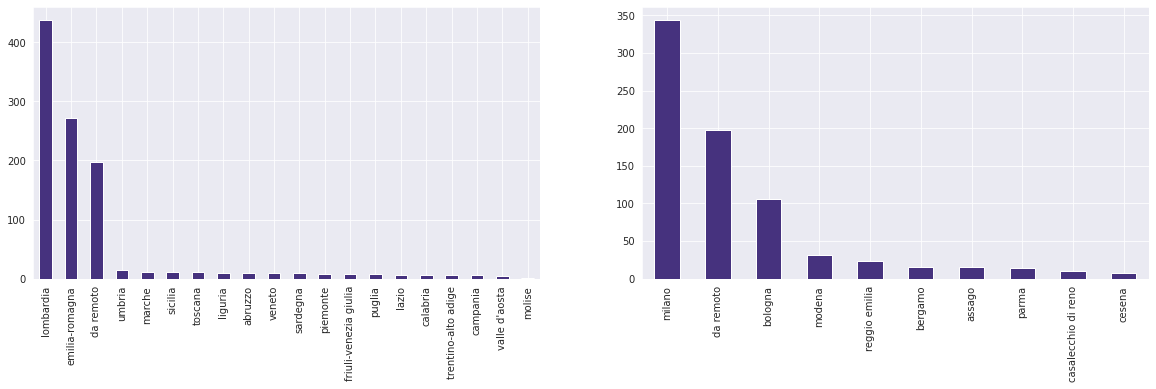

In [ ]:
# Offerte lavorative per città e regione
fig, axs = plt.subplots(ncols=2, figsize=(20, 5))
plt.xticks(rotation=90)
df_joblist['Regione'].value_counts().plot(kind='bar', ax=axs[0])
# Città: top 10 
df_joblist['Città'].value_counts().head(10).plot(kind='bar')

Distribuzione valori principali per regione
*   stipendio
*   requisiti totali richiesti
*   esperienza 







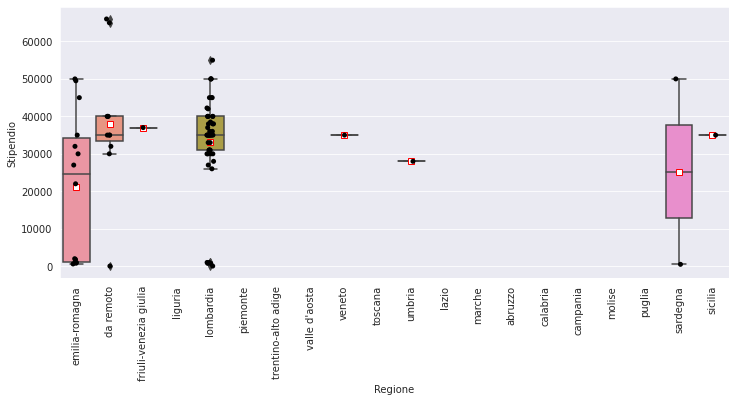

In [ ]:
# Stipendi per regione
fig, axs = plt.subplots(ncols=2, figsize=(24, 5))
plt.xticks(rotation=90)
sns.boxplot(x='Regione', y='Stipendio', data=df_joblist, showmeans=True,
            meanprops={"marker":"s", "markerfacecolor":"white", "markeredgecolor":"red"}, ax=axs[0])
sns.stripplot(x='Regione', y='Stipendio', data=df_joblist, color='black')
# Requisiti_tot per regione
sns.boxplot(x='Regione', y='Requisiti_tot', data=df_joblist, showmeans=True,
            meanprops={"marker":"s", "markerfacecolor":"white", "markeredgecolor":"red"}, ax=axs[1])
# Esperienza_in_anni per regione
sns.boxplot(x='Regione', y='Esperienza_in_anni', data=df_joblist, showmeans=True,
            meanprops={"marker":"s", "markerfacecolor":"white", "markeredgecolor":"red"}, ax=axs[2])

Raggruppamento regioni per area di appartenenza (Nord-Centro-Sud) e individuazione delle caratteristiche principali per ogni segmentazione



In [ ]:
# Raggruppamento regioni per area
Nord = ['emilia-romagna', 'friuli-venezia giulia', 'liguria', 'lombardia',
        'piemonte', 'trentino-alto adige', 'valle d\'aosta', 'veneto']
Centro = ['toscana',  'umbria', 'lazio', 'marche']
Sud = ['abruzzo', 'basilicata', 'calabria', 'campania', 
       'molise', 'puglia', 'sardegna', 'sicilia']
# Creazione dataframe con suddivsione regioni per area di appartenenza
df_territorio = df_joblist[['Regione', 'Stipendio', 'Requisiti_tot', 'Esperienza_in_anni']]

In [ ]:
# Assegnazione area appartenenza
for reg in df_territorio['Regione']:
    if reg in Nord:
        df_territorio['Regione'] = df_territorio['Regione'].replace(reg, 'nord')
    if reg in Centro:
        df_territorio['Regione'] = df_territorio['Regione'].replace(reg, 'centro')
    if reg in Sud:
        df_territorio['Regione'] = df_territorio['Regione'].replace(reg, 'sud')

df_territorio = df_territorio.rename(columns={'Regione': 'Area'})

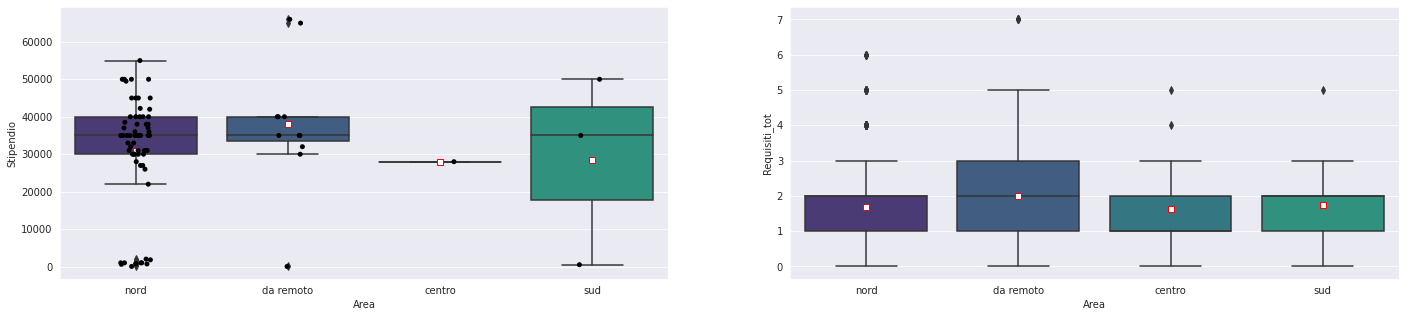

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(24, 5))
# Stipendio per area
sns.boxplot(x='Area', y='Stipendio', data=df_territorio, showmeans=True,
            meanprops={"marker":"s", "markerfacecolor":"white", "markeredgecolor":"red"}, ax=axs[0])
sns.stripplot(x='Area', y='Stipendio', data=df_territorio, color='black', ax=axs[0])
# Requisiti_tot per area
sns.boxplot(x='Area', y='Requisiti_tot', data=df_territorio, showmeans=True,
            meanprops={"marker":"s", "markerfacecolor":"white", "markeredgecolor":"red"}, ax=axs[1])
# Esperienza_in_anni per area
sns.boxplot(x='Area', y='Esperienza_in_anni', data=df_territorio, showmeans=True,
            meanprops={"marker":"s", "markerfacecolor":"white", "markeredgecolor":"red"}, ax=axs[2])

Verifica presenza correlazioni tra i vari elementi del Dataframe

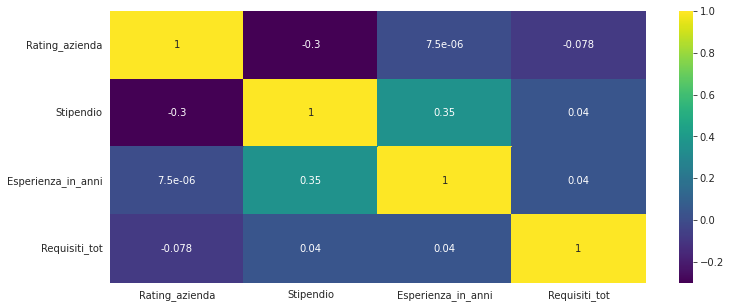

In [ ]:
# Correlazioni tra i valori numerici
plt.figure(figsize=(12, 5))
sns.heatmap(data=df_joblist.corr(), cmap='viridis', annot=True)

Visualizzazione correlazione stipendio con esperienza e requisiti totali richiesti 

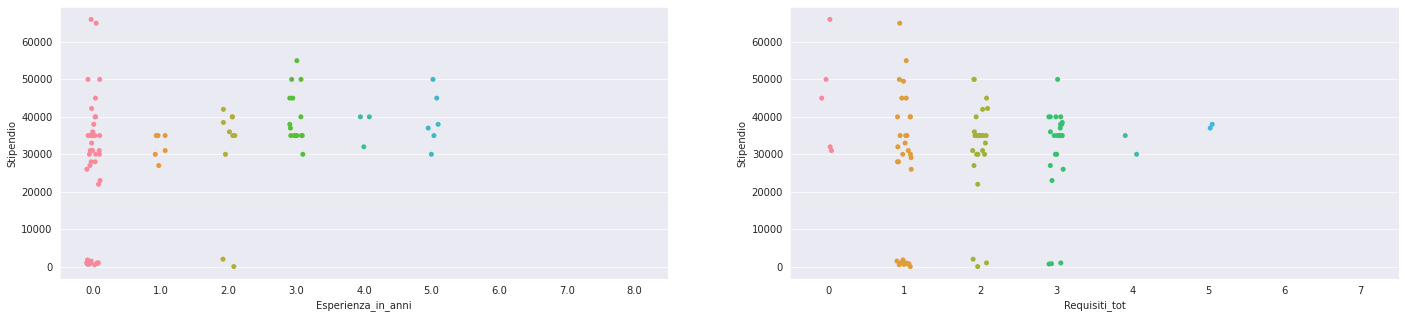

In [ ]:
# Visualizzazioni
fig, axs = plt.subplots(ncols=2, figsize=(24, 5))
sns.stripplot(x='Esperienza_in_anni', y='Stipendio', data=df_joblist, ax=axs[0])
sns.stripplot(x='Requisiti_tot', y='Stipendio', data=df_joblist)

Rappresentazione requisiti richiesti

In [ ]:
# Creazione Dataframe requisiti 
df_requisiti = pd.DataFrame({'requisiti': requisiti_primari,
                             'conteggio': [df_joblist[f'{req}'].count() for req in requisiti_primari]})

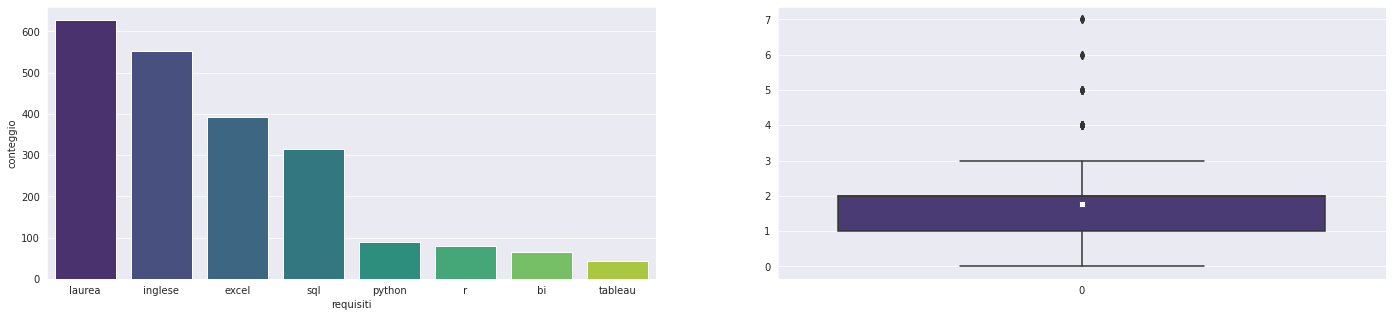

In [ ]:
# Visualizzazione requisiti
fig, axs = plt.subplots(ncols=2, figsize=(24, 5))
sns.barplot(x='requisiti', y='conteggio', data=df_requisiti.sort_values(by=['conteggio'], ascending=False), ax = axs[0], palette='viridis')
sns.boxplot(x='Requisiti_tot', data=df_joblist, showmeans=True, 
            meanprops={"marker":"s", "markerfacecolor":"white", "markeredgecolor":"red"})